## Database filtering

Data filtering the visual database related to rat's behavior - removal of movement interrupting acuity tests:
1. Rearing
2. Scratching
3. Moving around

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/'

dfrat = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')

hyperparam = { 'BPFlimit' : 0.5 ,
               'LPFlimit' : 0.13,
               'MOVElimit': 0.02,}


## Rearing removal
Removal based on Y axis postion limit - low pass filter

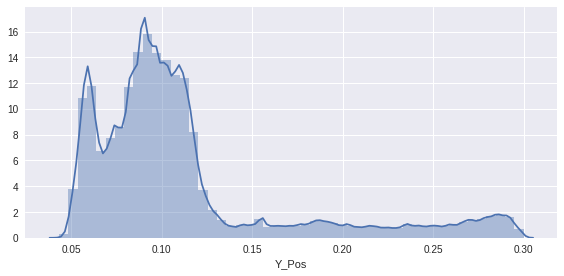

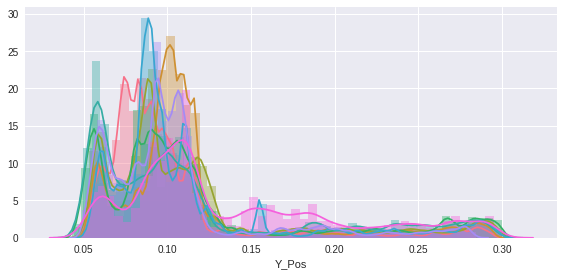

In [2]:
g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

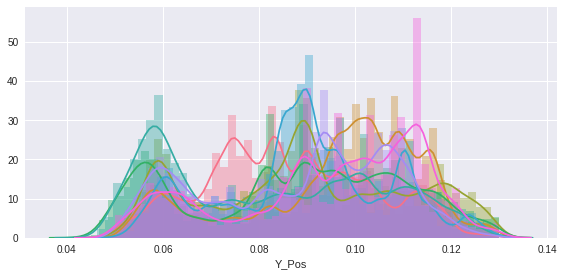

In [3]:
# Low pass filetring of Y position
rearinglimit = 0.13
dfratnew = dfrat[dfrat['Y_Pos'] < rearinglimit]

# Plotting after filtering
g = sns.FacetGrid(hue='session_id', data=dfratnew, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

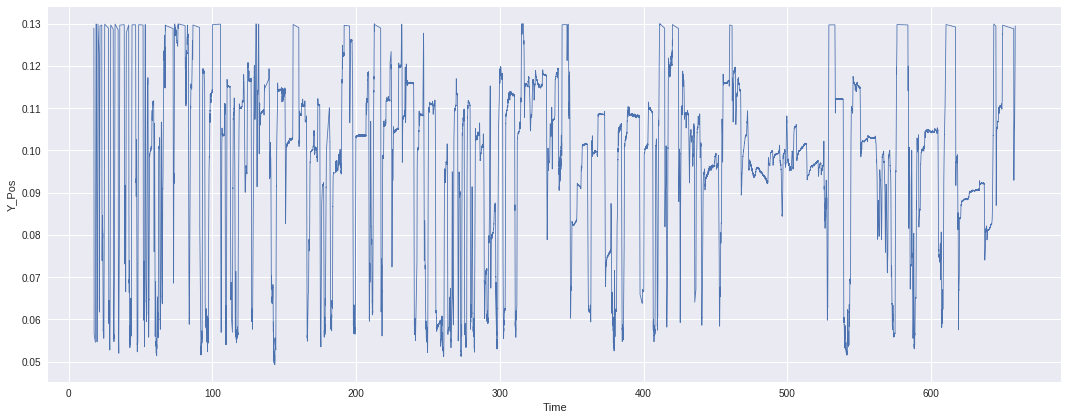

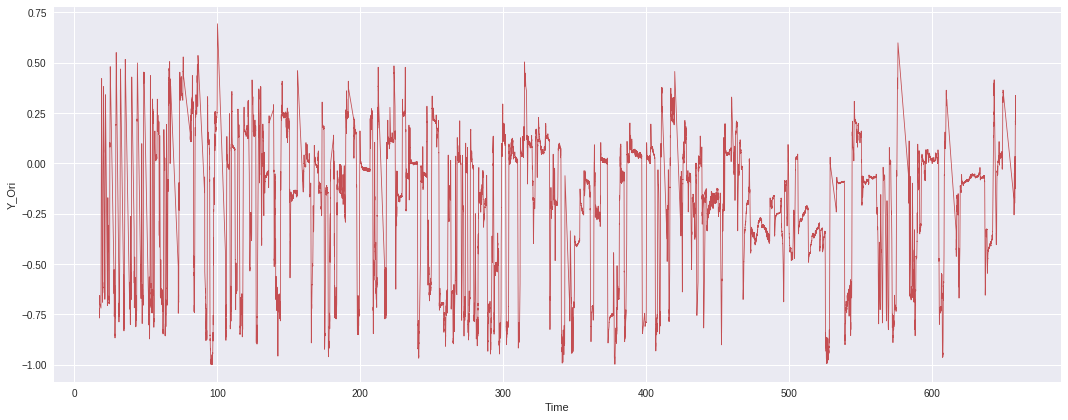

In [4]:
g = sns.FacetGrid(hue='session_id', data=dfratnew[dfratnew['session_id']==1], size=6, aspect=2.5)
#g.map(sns.regplot, 'Time', 'Y_Pos', scatter_kws={'s':2}, fit_reg=False);
g.map(plt.plot, "Time", "Y_Pos", alpha=1, linewidth=0.8);
g = sns.FacetGrid(hue='session_id', data=dfratnew[dfratnew['session_id']==1], size=6, aspect=2.5)
g.map(plt.plot, "Time", "Y_Ori", alpha=1, linewidth=0.8, color='r');


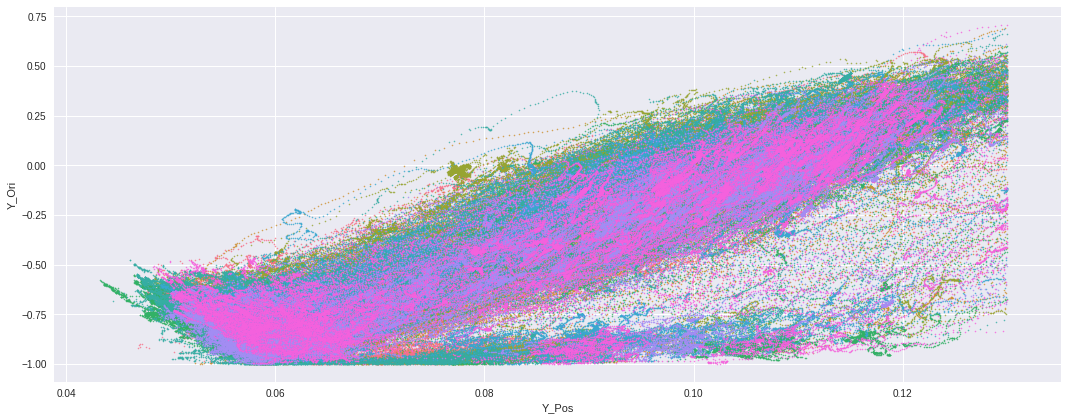

In [5]:
#g = sns.FacetGrid(hue='session_id', data=dfratnew[dfratnew['session_id']==1], size=6, aspect=2.5)
g = sns.FacetGrid(hue='session_id', data=dfratnew, size=6, aspect=2.5)
g.map(sns.regplot, 'Y_Pos', 'Y_Ori', scatter_kws={'s':2.5}, fit_reg=False);


## Scratching and cleaning removal
Removal based on Y axis orientation limit - band pass filter

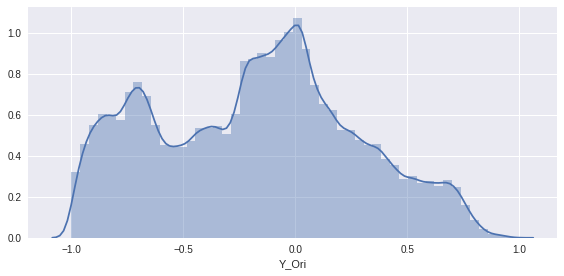

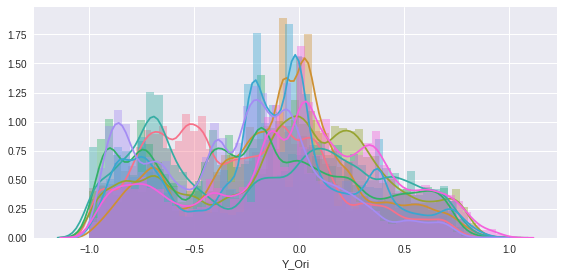

In [6]:
g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

# add line on plots with filter val

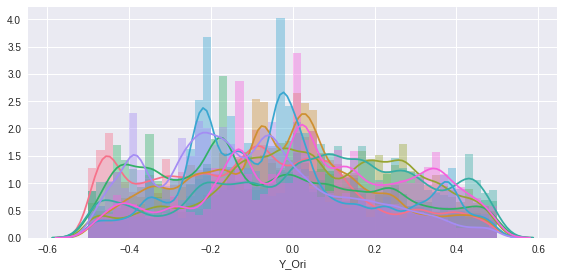

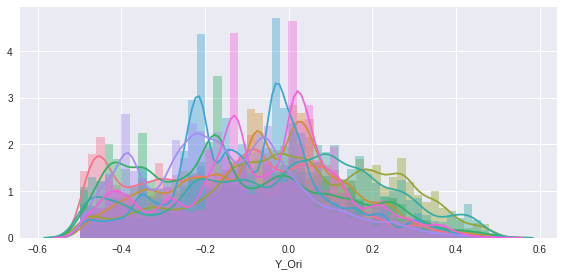

In [7]:
# Band pass filetring of Y orientation
orientylimit = 0.5
dfratnew2 = dfrat[np.absolute(dfrat['Y_Ori']) < orientylimit]
dfratnew3 = dfratnew[np.absolute(dfratnew['Y_Ori']) < orientylimit]

# Plotting after filtering
g = sns.FacetGrid(hue='session_id', data=dfratnew2, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');
g = sns.FacetGrid(hue='session_id', data=dfratnew3, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

## Rapid movement removal
Removal based on speed of changes in the position of the animal - low pass filter of diagonal velocity.

In [14]:
#extraction of speed of positon changes and calculating velocity in all axes
dfratnew4 = dfrat.copy()
dfratnew4['dT'] = dfratnew4['Time'].diff(-1)
dfratnew4['dX_Pos'] = dfratnew4['X_Pos'].diff(-1)
dfratnew4['dY_Pos'] = dfratnew4['Y_Pos'].diff(-1)
dfratnew4['dZ_Pos'] = dfratnew4['Z_Pos'].diff(-1)

dfratnew4['Vxyz'] = np.linalg.norm(dfratnew4[['dX_Pos','dY_Pos','dZ_Pos']].values,axis=1) # diagonal velocity

dfratnew4.head()


,Frame,Time,X_Pos,Y_Pos,Z_Pos,session_id,X_Ori,Y_Ori,Z_Ori,dT,dX_Pos,dY_Pos,dZ_Pos,Vxyz
index,,,,,,,,,,,,,,
0,0,0.000000,-0.085285,0.051115,-0.039564,0,-0.736724,-0.675770,-0.023923,-0.004167,-0.000094,-0.000049,-0.000023,0.000108
1,1,0.004167,-0.085192,0.051164,-0.039540,0,-0.735246,-0.677337,-0.025076,-0.004166,-0.000055,0.000132,0.000055,0.000153
2,2,0.008333,-0.085136,0.051032,-0.039595,0,-0.729050,-0.683372,-0.038595,-0.004167,-0.000033,-0.000213,-0.000174,0.000277
3,3,0.012500,-0.085103,0.051245,-0.039421,0,-0.735124,-0.677244,-0.030557,-0.004167,-0.000112,0.000107,0.000041,0.000160
4,4,0.016667,-0.084992,0.051138,-0.039461,0,-0.728125,-0.683970,-0.044930,-0.004166,-0.000120,-0.000060,-0.000054,0.000144


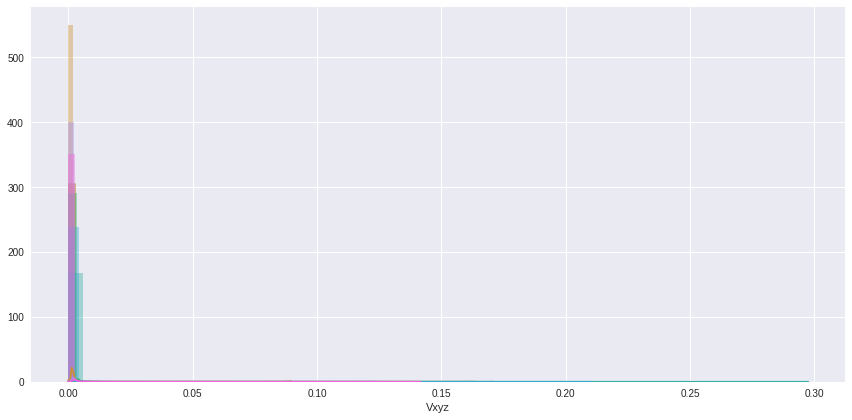

In [15]:
g = sns.FacetGrid(hue='session_id', data=dfratnew4, size=6, aspect=2)
g.map(sns.distplot, 'Vxyz');


In [16]:
pos_l = dfratnew4.melt(id_vars=['Frame', 'Time', 'session_id', 'Vxyz'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension'
          )
pos_l.head()

,Frame,Time,session_id,Vxyz,Dimension,Position
0,0,0.000000,0,0.000108,X_Pos,-0.085285
1,1,0.004167,0,0.000153,X_Pos,-0.085192
2,2,0.008333,0,0.000277,X_Pos,-0.085136
3,3,0.012500,0,0.000160,X_Pos,-0.085103
4,4,0.016667,0,0.000144,X_Pos,-0.084992


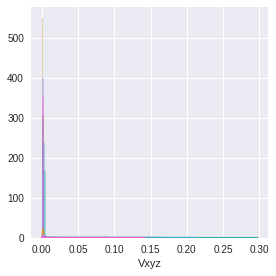

In [21]:
g = sns.FacetGrid(hue='session_id', data=pos_l, size=4)
g.map(sns.distplot, 'Vxyz');

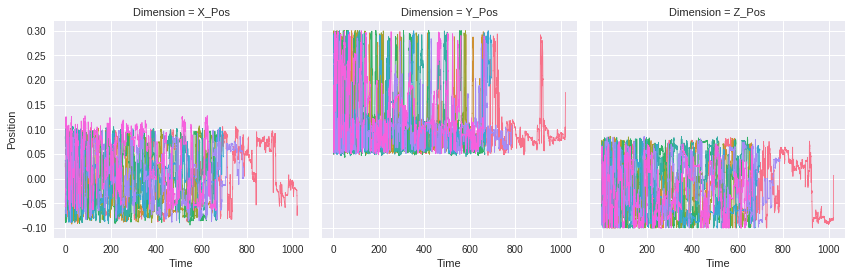

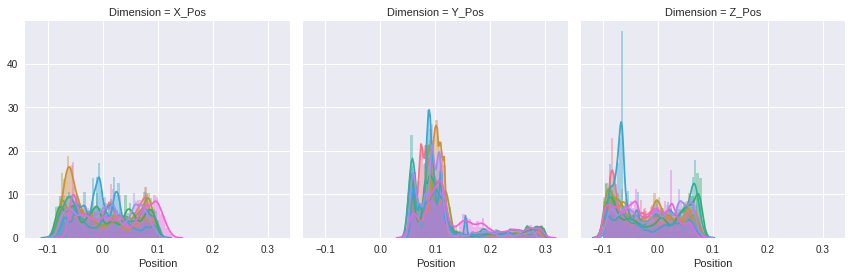

In [22]:
g = sns.FacetGrid(col='Dimension', hue='session_id', data=pos_l, size=4)
g.map(sns.distplot, 'Position');

g = sns.FacetGrid(col='Dimension', hue='session_id', data=pos_l, size=4)
g.map(plt.plot, "Time", "Position", alpha=1, linewidth=0.8);


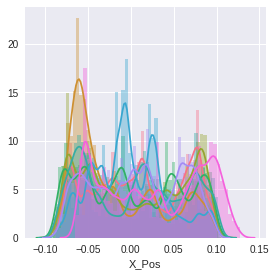

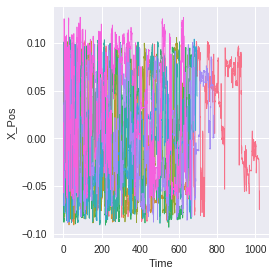

In [26]:
g = sns.FacetGrid(hue='session_id', data=pos_l, size=4)
g.map(sns.distplot, 'X_Pos');

g = sns.FacetGrid(hue='session_id', data=pos_l, size=4)
g.map(plt.plot, "Time", "X_Pos", alpha=1, linewidth=0.8);


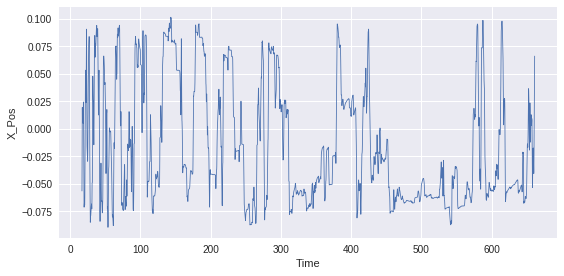

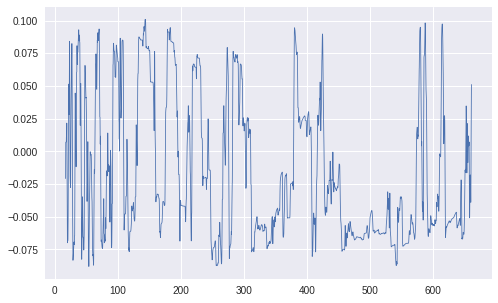

In [51]:

df = dfratnew4.copy()
df = df[df['session_id']==1]

#g = sns.FacetGrid(hue='session_id', data=df, size=4, aspect=2)
#g.map(plt.plot, "Time", "X_Pos", alpha=1, linewidth=0.8);

X_roll = df['X_Pos'].rolling(window=100).mean()
t = df['Time']

g = sns.FacetGrid(hue='session_id', data=df, size=4, aspect=2)
g.map(plt.plot, "Time", "X_Pos", alpha=1, linewidth=0.8);


fig = plt.figure(figsize=(8,5))
plt.plot(t, X_roll, alpha=1, linewidth=0.8);
plt.show()

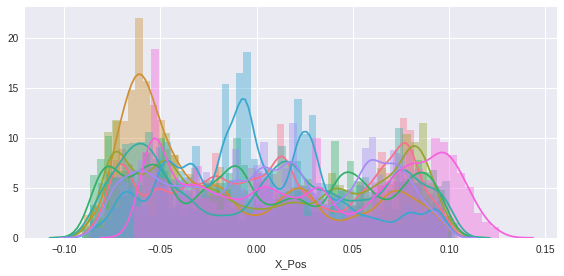

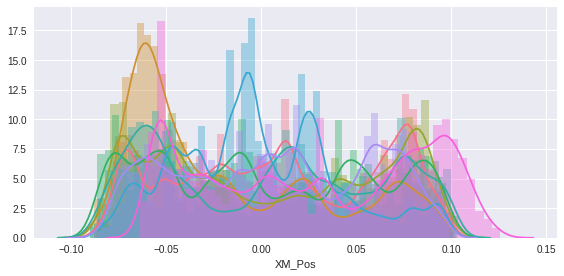

In [33]:

g = sns.FacetGrid(hue='session_id', data=dfratnew4, size=4, aspect=2)
g.map(sns.distplot, 'X_Pos');

g = sns.FacetGrid(hue='session_id', data=dfratnew4, size=4, aspect=2)
g.map(sns.distplot, 'XM_Pos');
